# Capstone Three Project :  Alcohol Sale Forecasting

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import warnings
warnings.filterwarnings("ignore")

# 2. Loading the data

In [2]:
# import data
Alcohol = pd.read_csv('Alcohol_Sales.csv')

# 3. Data Wrangling

In [3]:
# check the first 5 rows
Alcohol.head() 

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [4]:
# check the last five rows
Alcohol.tail()

,DATE,S4248SM144NCEN
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504
324,2019-01-01,10718


In [5]:
# describe the data in statistic form
Alcohol.describe()

,S4248SM144NCEN
count,325.000000
mean,7886.400000
std,2914.269061
min,3031.000000
25%,5231.000000
50%,7481.000000
75%,9977.000000
max,15504.000000


In [6]:
# check the name of the columns
Alcohol.columns

Index(['DATE', 'S4248SM144NCEN'], dtype='object')

In [7]:
# change the columns name to make it more readable
Alcohol.rename(columns={'DATE':'date', 'S4248SM144NCEN':'sold'}, inplace=True)
Alcohol.head()

,date,sold
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [8]:
# check if there are any missing values
Alcohol.isnull().sum()

date    0
sold    0
dtype: int64

In [9]:
# check if there are any duplicated data
Alcohol.duplicated().any()

False

In [10]:
# check the shape of the data
Alcohol.shape

(325, 2)

In [11]:
# check the general data information
Alcohol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    325 non-null    object
 1   sold    325 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


In [12]:
# sort the values by 'date'
Alcohol.sort_values(by='date')
Alcohol.head(20)

,date,sold
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
5,1992-06-01,4529
6,1992-07-01,4466
7,1992-08-01,4137
8,1992-09-01,4126
9,1992-10-01,4259


In [13]:
# check the data types
Alcohol.dtypes

date    object
sold     int64
dtype: object

In [14]:
# change the 'date' column to datetime frame
Alcohol['date']=pd.to_datetime(Alcohol['date'])

In [15]:
# check the data types again
Alcohol.dtypes

date    datetime64[ns]
sold             int64
dtype: object

In [16]:
# set the 'date' column to index
Alcohol=Alcohol.set_index('date')
Alcohol.head()

,sold
date,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [17]:
Alcohol.tail()

,sold
date,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


# 4. Exploratory Data Analysis And Visualization

## 4a. Data Visualization

<Axes: xlabel='date'>

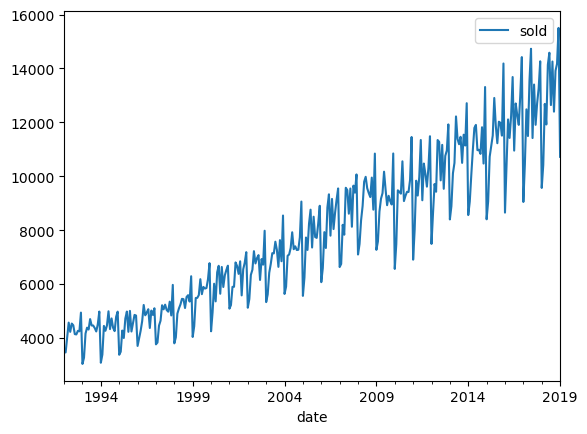

In [18]:
# visualize the data
Alcohol.plot()

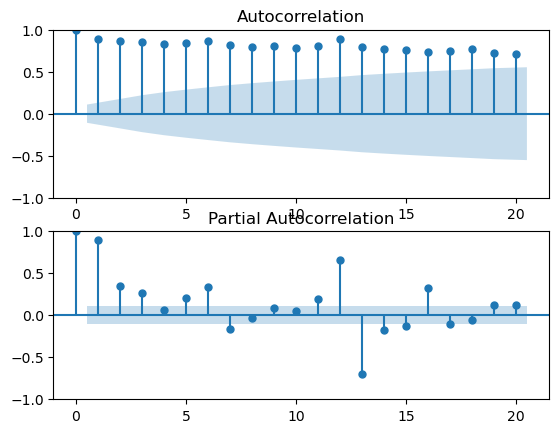

In [19]:
# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)
plot_acf(Alcohol, lags=20, ax=axes[0])
plot_pacf(Alcohol, lags=20, ax=axes[1])
plt.show()

## 4b. Stationary Check

In [20]:
# test data stationary
kpss(Alcohol)

(2.794429681699147,
 0.01,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [21]:
# use adfuller to test the stationary
adfuller(Alcohol['sold'])[1]

0.9987196267088919

# 5. Preprocessing Data

## 5a. Decompose

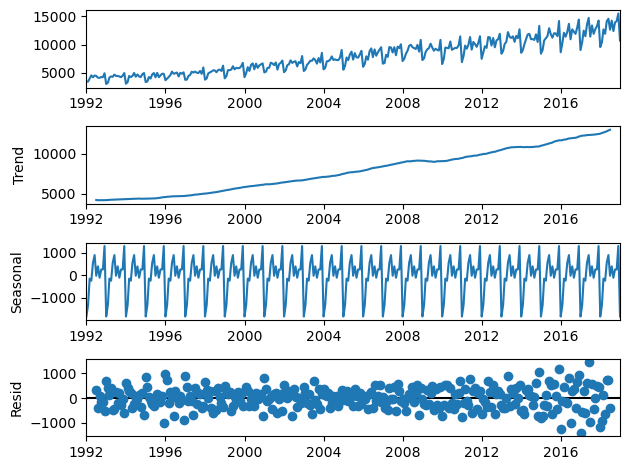

In [22]:
# decompose the datase
decomposition = seasonal_decompose(Alcohol, model='additive')
fig = decomposition.plot()
plt.show()

## 5b. Transforming Data

In [23]:
log = np.log(Alcohol)

<Axes: xlabel='date'>

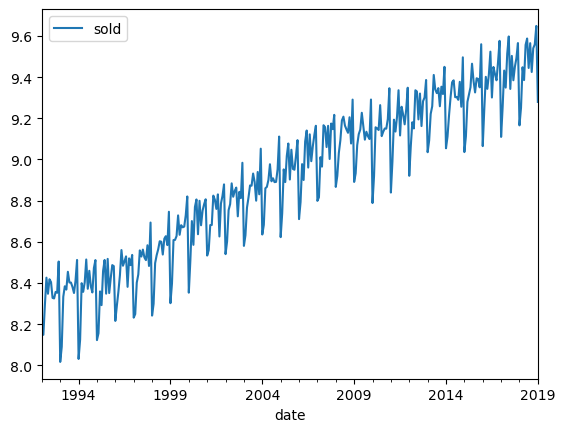

In [24]:
log.plot()

In [25]:
# Declare a variable using the differences of the log values
diff=log.diff().dropna()

<Axes: xlabel='date'>

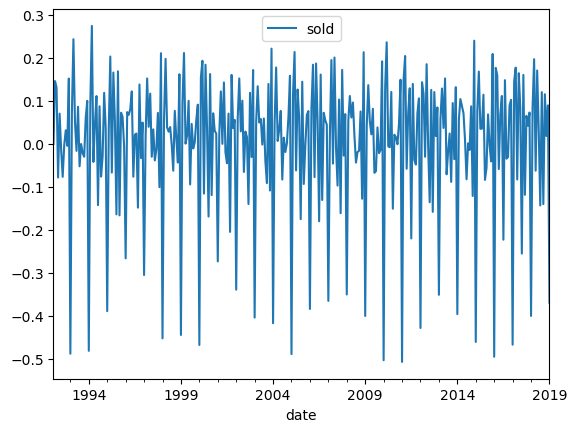

In [26]:
# Visualize the transformed data values
diff.plot()

In [27]:
# Test the stationary again
kpss(diff)

(0.0869598088182859,
 0.1,
 19,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [28]:
adfuller(diff)

(-5.609647994353132,
 1.2117033227158686e-06,
 13,
 310,
 {'1%': -3.451621854687657,
  '5%': -2.870908950689806,
  '10%': -2.571761810613944},
 -1083.5351086564988)

# 6. Modelling

## 6a. Choose ARIMA Model parameters

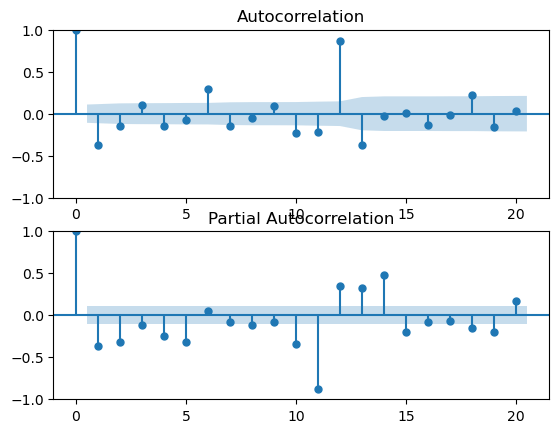

In [29]:
# Visualize the autocorrelation and partial autocorrelation after transforming the data
fig, axes = plt.subplots(2,1)
plot_acf(diff, lags=20, ax=axes[0])
plot_pacf(diff, lags=20, ax=axes[1])
plt.show()

In [30]:
from pmdarima.arima import auto_arima
model_a = auto_arima(Alcohol, trace=True, error_action='ignore', suppress_warnings=True)
model_a.fit(diff)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5581.852, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5521.140, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5399.757, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5579.946, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5400.180, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5399.909, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5427.084, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.642 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [31]:
# search over to find the best parameters
for p in range(3):
    for q in range(3):
        try:
            model_s = ARIMA(Alcohol, order=(p,1,q))
            results_s = model_s.fit()
            print(p, q, results_s.aic, results_s.bic)
        except:
            print(p, q, None, None)      

0 0 5579.945770964523 5583.726514480315
0 1 5427.08389097486 5434.645378006445
0 2 5427.2796314290445 5438.621861976421
1 0 5519.509371486854 5527.070858518439
1 1 5427.5284702091985 5438.870700756575
1 2 5428.334154846564 5443.457128909734
2 0 5484.955283809666 5496.297514357043
2 1 5428.077375036161 5443.200349099331
2 2 5393.065193686784 5411.968911265746


## 6b. Fit an ARIMA model

<Axes: xlabel='date'>

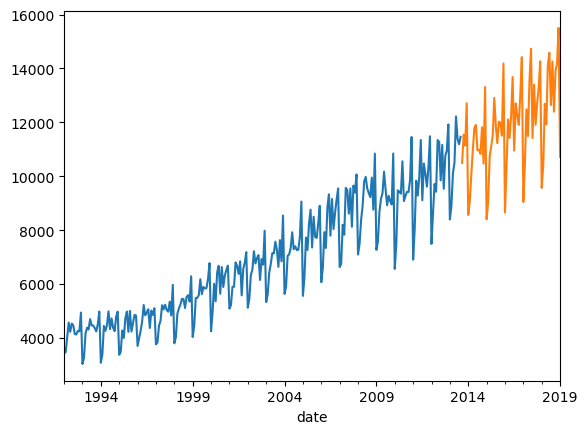

In [32]:
# Split the data to train and test
train, test = Alcohol[:int(0.8*(len(Alcohol)))], Alcohol[int(0.8*(len(Alcohol))):]
train['sold'].plot()
test['sold'].plot()

In [34]:
model = ARIMA(train, order=(0,1,1))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   sold   No. Observations:                  260
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2124.634
Date:                Sun, 18 Jun 2023   AIC                           4253.268
Time:                        12:07:46   BIC                           4260.382
Sample:                    01-01-1992   HQIC                          4256.128
                         - 08-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8514      0.029    -29.772      0.000      -0.907      -0.795
sigma2      7.696e+05   6.91e+04     11.136      0.000    6.34e+05    9.05e+05
Ljung-Box (L1) (Q):                   1.25   Jarque-

## 6c. Plot ARIMA Model

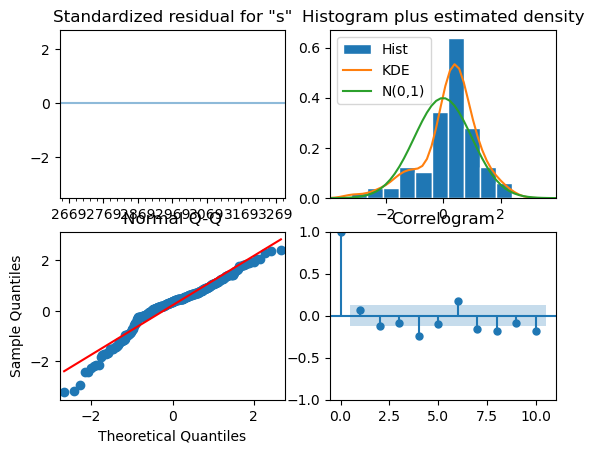

In [35]:
result.plot_diagnostics()
plt.show()

In [36]:
mae = np.mean(np.abs(result.resid))
print(mae)

699.5644090775342


## 6d. Forecasting

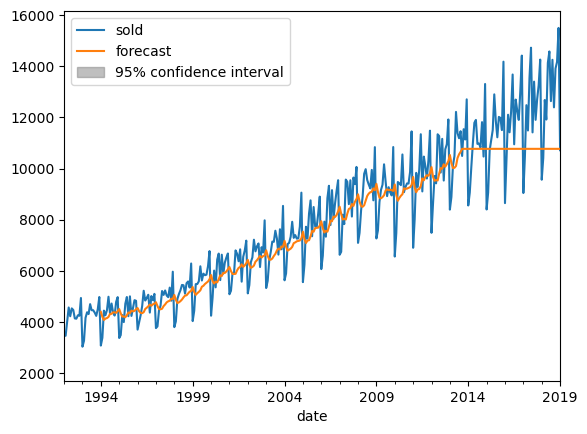

In [40]:
# Plot the original series and the forecasted series
fig, ax = plt.subplots()
Alcohol.plot(ax=ax)
plot_predict(result, start='1994', end='2019', alpha=0.05, ax=ax)
plt.show()